In [46]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
NB_WORDS = 10000  
VAL_SIZE = 1000  
NB_START_EPOCHS = 20  
BATCH_SIZE = 512  

In [48]:
df = pd.read_csv('/content/sample_data/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
12522,@AmericanAir just hoping/praying for a safe fl...,neutral
3147,@united what is your plan to reduce delays?,neutral
9623,@USAirways merging with American will negative...,negative
3628,@united We invite to Fallow @HelacoHLC learn a...,neutral
12946,@AmericanAir WHERE IS MY BAG?!?!?!,negative


In [49]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [50]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
12522,hoping/praying safe flight. They've stop de-i...,neutral
3147,plan reduce delays?,neutral
9623,merging American negatively affect quality in...,negative
3628,We invite Fallow learn activities.Prevention...,neutral
12946,WHERE IS MY BAG?!?!?!,negative


In [51]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('Train data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

Train data samples: 13176
Test data samples: 1464


In [52]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3543), ('not', 1429), ('no', 1348), ('get', 1209), ('t', 1098)]


In [53]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

" What  said." is converted into [111, 2877, 59, 941, 105, 699, 30]


In [54]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

In [55]:
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[111, 2877, 59, 941, 105, 699, 30]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 7.0 features with a value of 1.


In [56]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


In [57]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


In [58]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                640064    
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [59]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [60]:
base_history = deep_model(base_model)

In [61]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

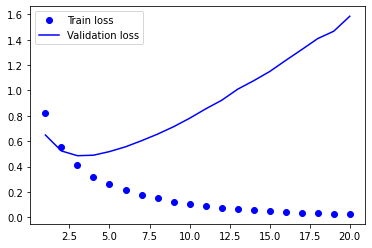

In [62]:
eval_metric(base_history, 'loss')

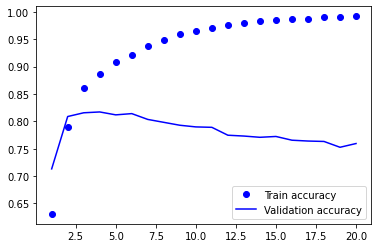

In [63]:
eval_metric(base_history, 'accuracy')

In [64]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                320032    
                                                                 
 dense_15 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [65]:
reduced_history = deep_model(reduced_model)

In [66]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

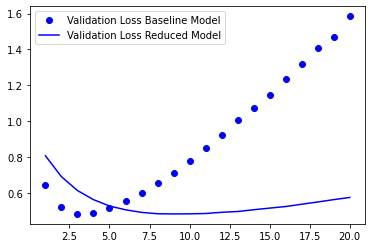

In [67]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [68]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                640064    
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [69]:
reg_history = deep_model(reg_model)

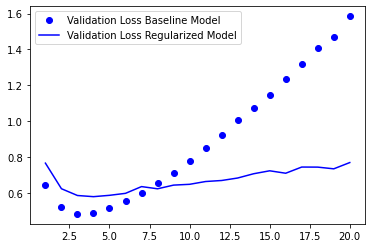

In [70]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [71]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                640064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [72]:
drop_history = deep_model(drop_model)

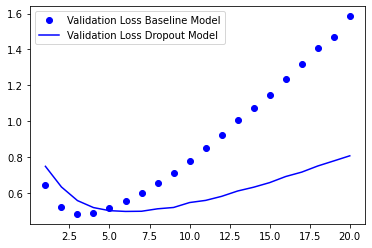

In [73]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [74]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [75]:
base_results = test_model(base_model, 4)
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

46/46 [==============================] - 0s 3ms/step - loss: 1.2531 - accuracy: 0.7439
Test accuracy of baseline model: 74.39%


In [76]:
reduced_results = test_model(reduced_model, 10)
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

46/46 [==============================] - 0s 3ms/step - loss: 0.7402 - accuracy: 0.7780
Test accuracy of reduced model: 77.80%


In [77]:
reg_results = test_model(reg_model, 5)
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

46/46 [==============================] - 0s 3ms/step - loss: 0.7532 - accuracy: 0.7766
Test accuracy of regularized model: 77.66%


In [78]:
drop_results = test_model(drop_model, 6)
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

46/46 [==============================] - 0s 3ms/step - loss: 0.9158 - accuracy: 0.7855
Test accuracy of dropout model: 78.55%
